In [81]:
# importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
# ignore warnings if any occur
import warnings
warnings.filterwarnings('ignore')

In [83]:
# Load the dataset
data = pd.read_csv('stars_data.csv')
data.head(5)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


#### Data Visualisation

In [84]:
# checking shape of the dataset
data.shape

(240, 7)

In [85]:
# columns for dataset
data.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color', 'Spectral Class'],
      dtype='object')

In [86]:
# statistics of the dataset
data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [87]:
data.isnull().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

In [88]:
data.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

In [89]:
data.nunique()

Temperature (K)           228
Luminosity(L/Lo)          208
Radius(R/Ro)              216
Absolute magnitude(Mv)    228
Star type                   6
Star color                 19
Spectral Class              7
dtype: int64

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


#### Target class

In [91]:
data['Spectral Class'].value_counts()

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral Class, dtype: int64

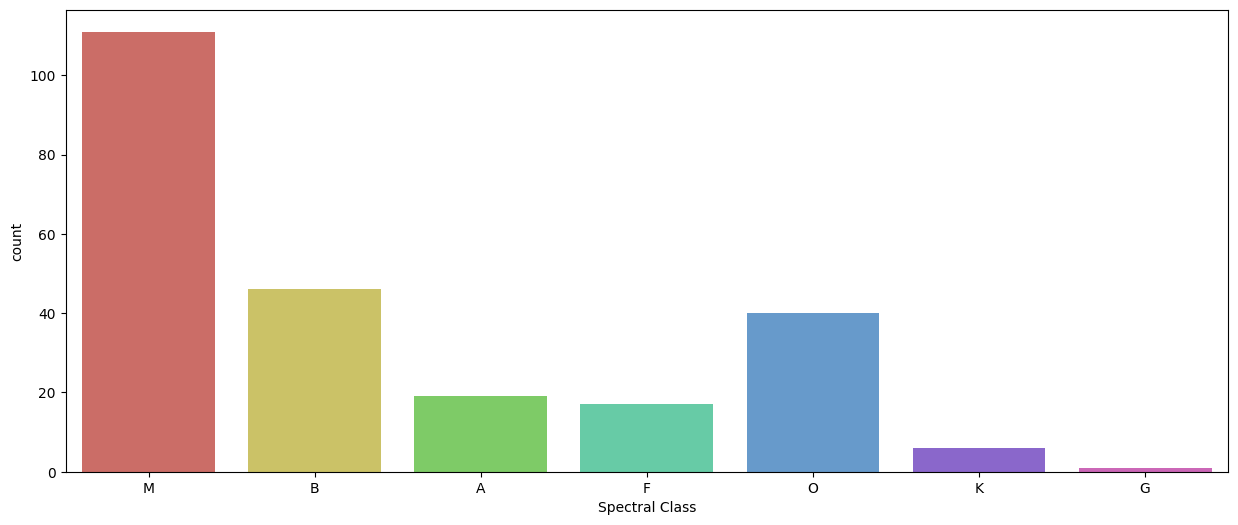

In [92]:
plt.figure(figsize=(15,6))
sns.countplot(data,x=data['Spectral Class'],
               palette = 'hls')
plt.xticks(rotation = 0)
plt.show()

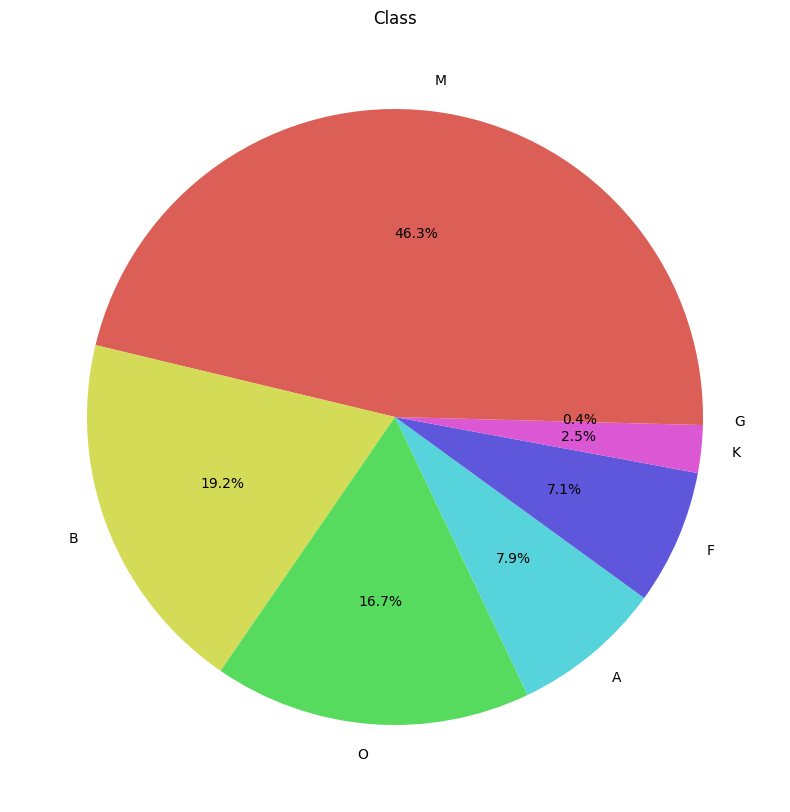

In [93]:
plt.figure(figsize=(10, 10))
counts = data['Spectral Class'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=sns.color_palette('hls'))
plt.title('Class')
plt.show()

#### We can see there is imbalance in the dataset. Class G has only one data sample in it's class. So we will deal with it using the SMOTE technique later in the code.

In [94]:
class_counts = data['Spectral Class'].value_counts()
class_counts

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral Class, dtype: int64

#### Before removing the Class G, the count of all classes look like the following

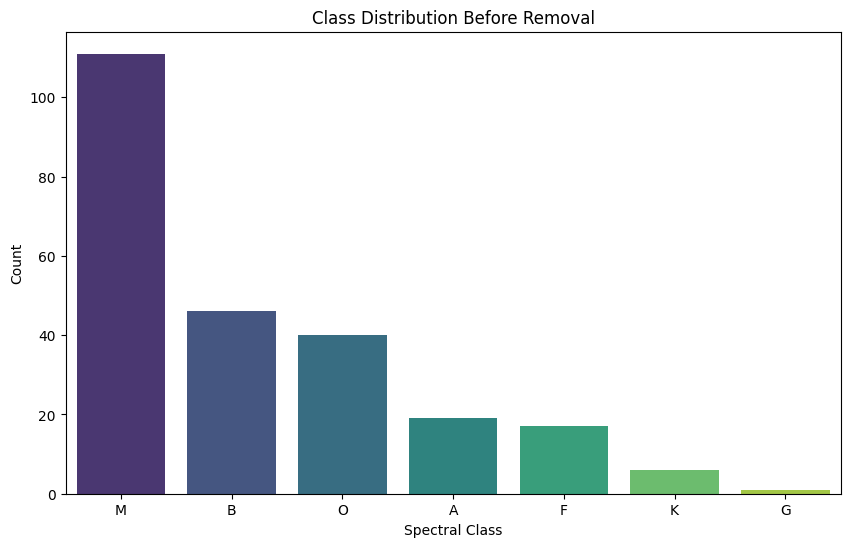

In [95]:
# Plotting class distribution before removal
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution Before Removal')
plt.xlabel('Spectral Class')
plt.ylabel('Count')
plt.show()


In [96]:
# Removing classes with less than 2 samples
min_samples = 2
classes_to_keep = class_counts[class_counts >= min_samples].index
data = data[data['Spectral Class'].isin(classes_to_keep)]

#### After removing the Class G, the count of all classes look like the following

In [97]:
# Checking class distribution after removal
class_counts_after = data['Spectral Class'].value_counts()
class_counts_after

M    111
B     46
O     40
A     19
F     17
K      6
Name: Spectral Class, dtype: int64

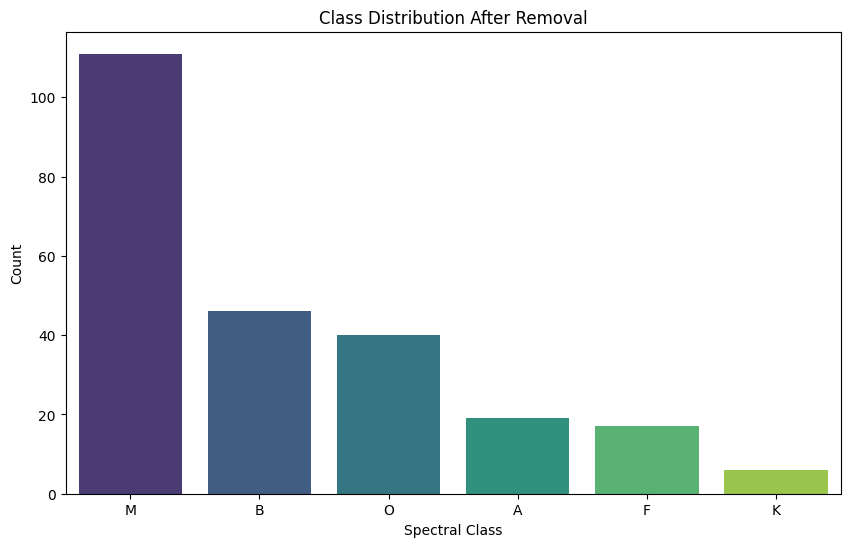

In [98]:
# Plotting class distribution after removal
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts_after.index, y=class_counts_after.values, palette='viridis')
plt.title('Class Distribution After Removal')
plt.xlabel('Spectral Class')
plt.ylabel('Count')
plt.show()

In [99]:
# Encoding the target variable since it is categorical 
target_encoder = LabelEncoder()
data['Spectral Class'] = target_encoder.fit_transform(data['Spectral Class'])

In [100]:
# Defining the features and target
X = data.drop('Spectral Class', axis=1)
y = data['Spectral Class']


In [101]:
# Identifying the categorical feature
cat_features = ['Star color']

### Preprocessing Pipeline

The following code block makes use of a preprocessing pipeline using `ColumnTransformer`integrating two key transformations:

- **Numerical Features Scaling**: Rescaling the numerical features with `StandardScaler` to achieve a mean of zero and variance of one benefits various machine learning algorithms, particularly those that rely on distance computations like K-means clustering and k-nearest neighbors.


- **Categorical Features Encoding**: Utilizing `OneHotEncoder` to transform categorical features converting every category into a separate binary column, a requirement for models that need numeric input. The parameter `handle_unknown='ignore'` makes sure that unknown categories are considered uninformative during transformation, instead of triggering an error. 

These changes are essential in getting the dataset ready for successful model training by standardizing feature scales and converting categorical data into a format readable by machines. 


In [102]:
# Preprocessing pipeline for numeric and categorical features
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

In [103]:
# Fit and transform the features
X_processed = preprocessing_pipeline.fit_transform(X).toarray()  # Ensure the output is dense

In [104]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

### Handling Class Imbalance with SMOTE

This section of the code is dedicated to solving the issue of imbalanced class distribution in our dataset. Unequal distribution of classes can affect the performance of machine learning models significantly,leading them to exhibit bias towards the dominant class, hence we utilize the Synthetic Minority Over-sampling Technique (SMOTE).
SMOTE generates synthetic instances for the minority class to achieve class balance before model training. This procedure includes selecting samples close by in the feature space, linking them with a line, and generating a fresh sample at a position on that line.
Create a new account to use the platform.
- By setting `random_state=42`, the consistency of outcomes is ensured as it provides a fixed seed for producing random numbers.
- `k_neighbors=1`: Specifies that the creation of synthetic samples should consider only one closest neighbor. This is particularly advantageous when minority groups have a small sample size.
By utilizing SMOTE for data resampling, we enhance the model's ability to learn from an evenly distributed dataset, leading to improved generalization and reducing the risk of overfitting to the majority class. 


In [105]:
# Handling class imbalance using SMOTE with k_neighbors=1
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

### Re-encoding Labels

We utilize `LabelEncoder` to change the balanced class labels into a format that is appropriate for training, ensuring that the same conversion is used on both the training and testing data to uphold consistency. 


In [106]:
# Re-encoding the balanced labels
label_encoder_balancing = LabelEncoder()
y_train_bal_encoded = label_encoder_balancing.fit_transform(y_train_bal)
y_test_encoded = label_encoder_balancing.transform(y_test)

In [107]:
# Computing number of classes after re-encoding
num_classes_balanced = len(label_encoder_balancing.classes_)
num_classes_balanced

6

### Categorical Label Conversion

Transforms training and test labels into a binary matrix format that is compatible with neural network models by utilizing TensorFlow's `to_categorical` function, which is crucial for multi-class classification assignments. 


In [108]:
# Converting labels to categorical for neural networks
y_train_cat = to_categorical(y_train_bal_encoded, num_classes=num_classes_balanced)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes_balanced)

In [109]:
# Ensuring that the data is in the correct shape and format
print("X_train_after_balanced shape:", X_train_bal.shape)
print("y_train_categorical shape:", y_train_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_categorical shape:", y_test_cat.shape)

X_train_after_balanced shape: (468, 24)
y_train_categorical shape: (468, 6)
X_test shape: (72, 24)
y_test_categorical shape: (72, 6)


#### Models

#### Decision Tree Classifier - Supervised Learning

In [110]:
# Decision Tree Classifier
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train_bal, y_train_bal_encoded)
y_pred_dtc = dtc_model.predict(X_test)
dtc_accuracy = accuracy_score(y_test_encoded, y_pred_dtc)
dtc_report = classification_report(y_test_encoded, y_pred_dtc)

In [111]:
print("Decision Tree Accuracy:", dtc_accuracy)
print("Decision Tree Classification Report:\n", dtc_report)

Decision Tree Accuracy: 0.875
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.85      0.79      0.81        14
           2       0.50      0.20      0.29         5
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00        33
           5       0.92      1.00      0.96        12

    accuracy                           0.88        72
   macro avg       0.74      0.78      0.74        72
weighted avg       0.87      0.88      0.87        72



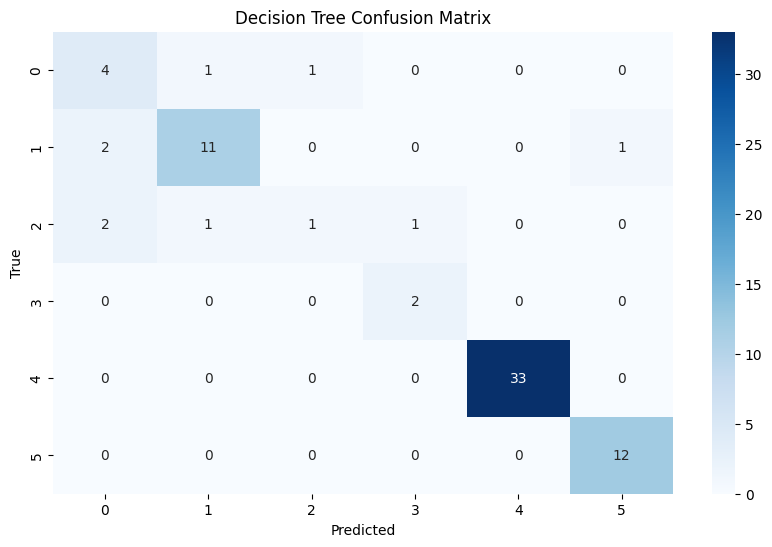

In [112]:
# Plot confusion matrix for Decision Tree
conf_matrix_dtc = confusion_matrix(y_test_encoded, y_pred_dtc)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_dtc, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### K-Means Clustering - Unsupervised Learning

In [113]:
# K-Means Clustering
kmeans_model = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans_model.fit(X_train_bal)
y_pred_kmeans = kmeans_model.predict(X_test)
kmeans_ari = adjusted_rand_score(y_test_encoded, y_pred_kmeans)

print("K-Means Adjusted Rand Index:", kmeans_ari)

K-Means Adjusted Rand Index: 0.43887953610175834


#### MLP Neural Network 

In [114]:
# MLP Neural Network
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dense(64, activation='relu'),
    Dense(num_classes_balanced, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [115]:
# Training the MLP neural network
mlp_model.fit(X_train_bal, y_train_cat, epochs=50, batch_size=16, validation_data=(X_test, y_test_cat))
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test_cat)
print("MLP Accuracy:", mlp_accuracy)

Epoch 1/50
30/30 [==============================] - 1s 14ms/step - loss: 1.6141 - accuracy: 0.4231 - val_loss: 1.2517 - val_accuracy: 0.6667
Epoch 2/50
30/30 [==============================] - 0s 5ms/step - loss: 1.2156 - accuracy: 0.7457 - val_loss: 0.9095 - val_accuracy: 0.6944
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.8440 - accuracy: 0.7970 - val_loss: 0.6936 - val_accuracy: 0.7361
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.5496 - accuracy: 0.9103 - val_loss: 0.5585 - val_accuracy: 0.7917
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.3576 - accuracy: 0.9274 - val_loss: 0.4676 - val_accuracy: 0.8056
Epoch 6/50
30/30 [==============================] - 0s 4ms/step - loss: 0.2473 - accuracy: 0.9509 - val_loss: 0.4241 - val_accuracy: 0.8611
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.1905 - accuracy: 0.9444 - val_loss: 0.4176 - val_accuracy: 0.8611
Epoch 8/50
30/30 [=

3/3 [==============================] - 0s 5ms/step


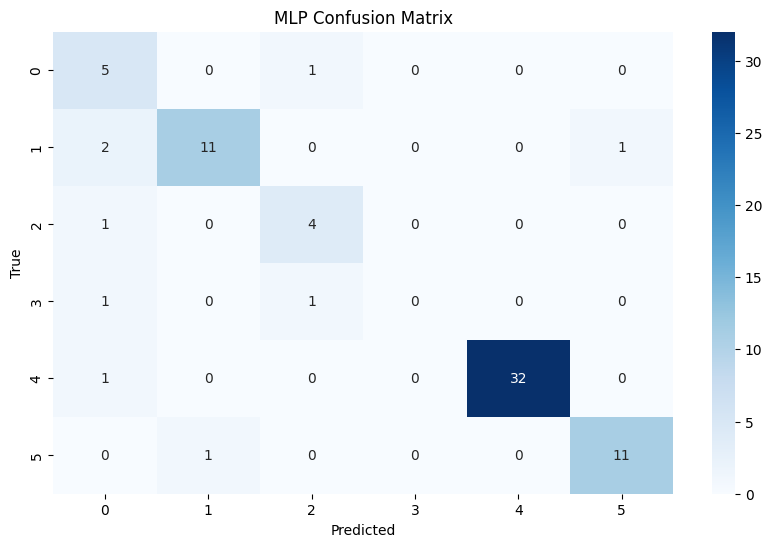

In [116]:
# Plotting confusion matrix for MLP
y_pred_mlp = mlp_model.predict(X_test)
y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)
conf_matrix_mlp = confusion_matrix(y_test_encoded, y_pred_mlp_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### CNN

In [117]:
# CNN
X_train_cnn = X_train_bal.reshape(X_train_bal.shape[0], X_train_bal.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes_balanced, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
# Training the CNN neural network
cnn_model.fit(X_train_cnn, y_train_cat, epochs=50, batch_size=16, validation_data=(X_test_cnn, y_test_cat))
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cat)
print("CNN Accuracy:", cnn_accuracy)


Epoch 1/50
30/30 [==============================] - 1s 13ms/step - loss: 1.5918 - accuracy: 0.5812 - val_loss: 1.1569 - val_accuracy: 0.9028
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 1.0380 - accuracy: 0.8846 - val_loss: 0.6033 - val_accuracy: 0.8472
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.5648 - accuracy: 0.9252 - val_loss: 0.4731 - val_accuracy: 0.8472
Epoch 4/50
30/30 [==============================] - 0s 4ms/step - loss: 0.3477 - accuracy: 0.9359 - val_loss: 0.4818 - val_accuracy: 0.8889
Epoch 5/50
30/30 [==============================] - 0s 4ms/step - loss: 0.2478 - accuracy: 0.9423 - val_loss: 0.5013 - val_accuracy: 0.8333
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 0.1985 - accuracy: 0.9551 - val_loss: 0.4539 - val_accuracy: 0.9167
Epoch 7/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1663 - accuracy: 0.9530 - val_loss: 0.5084 - val_accuracy: 0.9167
Epoch 8/50
30/30 [=

3/3 [==============================] - 0s 449us/step


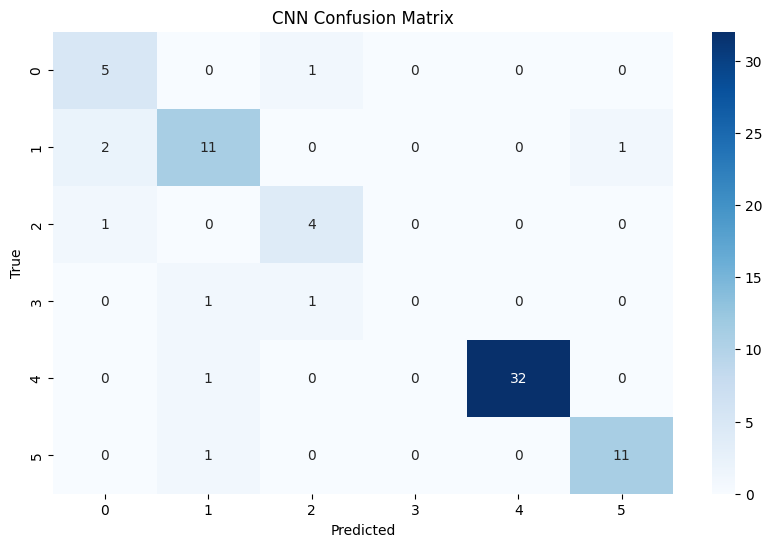

In [119]:
# Plotting confusion matrix for CNN
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
conf_matrix_cnn = confusion_matrix(y_test_encoded, y_pred_cnn_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Comaprison of the four models using Accuracy

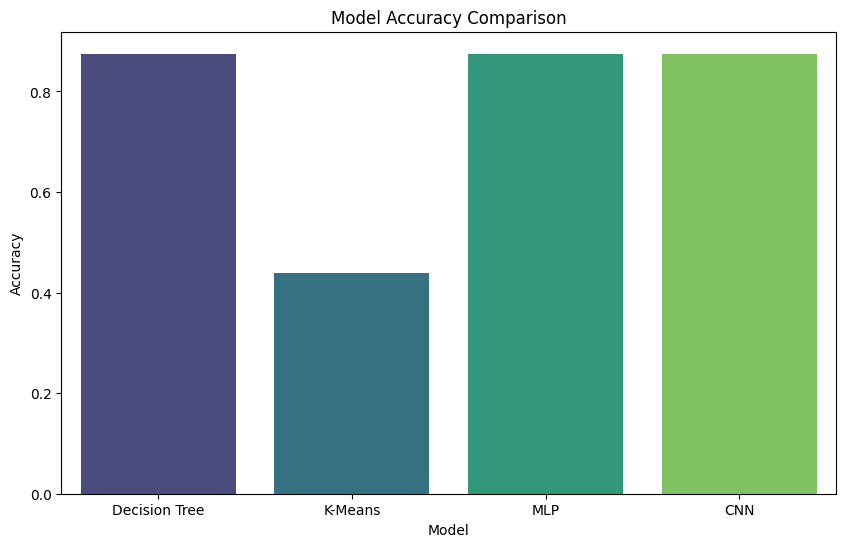

In [120]:
# Accuracy comparison
models_to_compare = ['Decision Tree', 'K-Means', 'MLP', 'CNN']
accuracies = [dtc_accuracy, kmeans_ari, mlp_accuracy, cnn_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models_to_compare, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()